In [1]:
import numpy as np
import time, os, sys
from glob import glob
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96

from cellpose import utils, models, transforms
from mxnet import ndarray as nd
from mxnet.gluon import nn

In [ ]:
# I will download images from website
urls = ['http://www.cellpose.org/static/images/img02.png',
        'http://www.cellpose.org/static/images/img03.png',
        'http://www.cellpose.org/static/images/img05.png']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']
    
imgs = [skimage.io.imread(f) for f in files]
nimg = len(imgs)

plt.figure(figsize=(12,4))
for k,img in enumerate(imgs):
    plt.subplot(1,3,k+1)
    plt.imshow(img)

## Cellpose Model Initialization

In [2]:
model0 = models.Cellpose(batch_size=8)
cpnet = model0.cp.net
cpnet.hybridize()
# cpnet.collect_params().initialize()
cpnet.summary

>>>> using CPU


<bound method Block.summary of CPnet(
  (downsample): downsample(
    (down): HybridSequential(
      (0): resdown(
        (conv): HybridSequential(
          (0): HybridSequential(
            (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
            (1): Activation(relu)
            (2): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): HybridSequential(
            (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
            (1): Activation(relu)
            (2): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (2): HybridSequential(
            (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
            (1): Activation(relu)
            (2): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

In [55]:
cpnet.downsample.summary

<bound method Block.summary of downsample(
  (down): HybridSequential(
    (0): resdown(
      (conv): HybridSequential(
        (0): HybridSequential(
          (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=2)
          (1): Activation(relu)
          (2): Conv2D(2 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): HybridSequential(
          (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
          (1): Activation(relu)
          (2): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): HybridSequential(
          (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
          (1): Activation(relu)
          (2): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (3): HybridSequential(
          (0): BatchNorm(axis=1, eps=

In [59]:
cpnet.make_style.summary

<bound method Block.summary of make_style(
  (pool_all): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
  (flatten): Flatten
)>

## Loading input files

In [30]:
# X = sorted(glob('/home/qzt/data/centuri/train/images/*.tif'))
# Y = sorted(glob('/home/qzt/data/centuri/train/masks/*.tif'))
X_file = sorted(glob('/home/qzt/data/dsb2018/train/images/*.tif'))
# Y = sorted(glob('/home/qzt/data/dsb2018/train/masks/*.tif'))

# X_file = [os.path.split(f)[-1] for f in X]
# assert all(Path(x).name==Path(y).name for x,y in zip(X,Y_file))
print(X_file[0])

/home/qzt/data/dsb2018/train/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.tif


In [31]:
X = list(map(skimage.io.imread, X_file))
# Y = list(map(imread,Y))

print(len(X))
print(len(X_file))

# axis_norm = (0,1) # normalized Y and X
# ptl_low = 1
# ptl_high = 99.8
# X = [normalize(x, ptl_low, ptl_high, axis=axis_norm) for x in tqdm(X)]
# # Y = [fill_label_holes(y) for y in tqdm(Y)]

447
447


(256, 256)


(-0.5, 255.5, 255.5, -0.5)

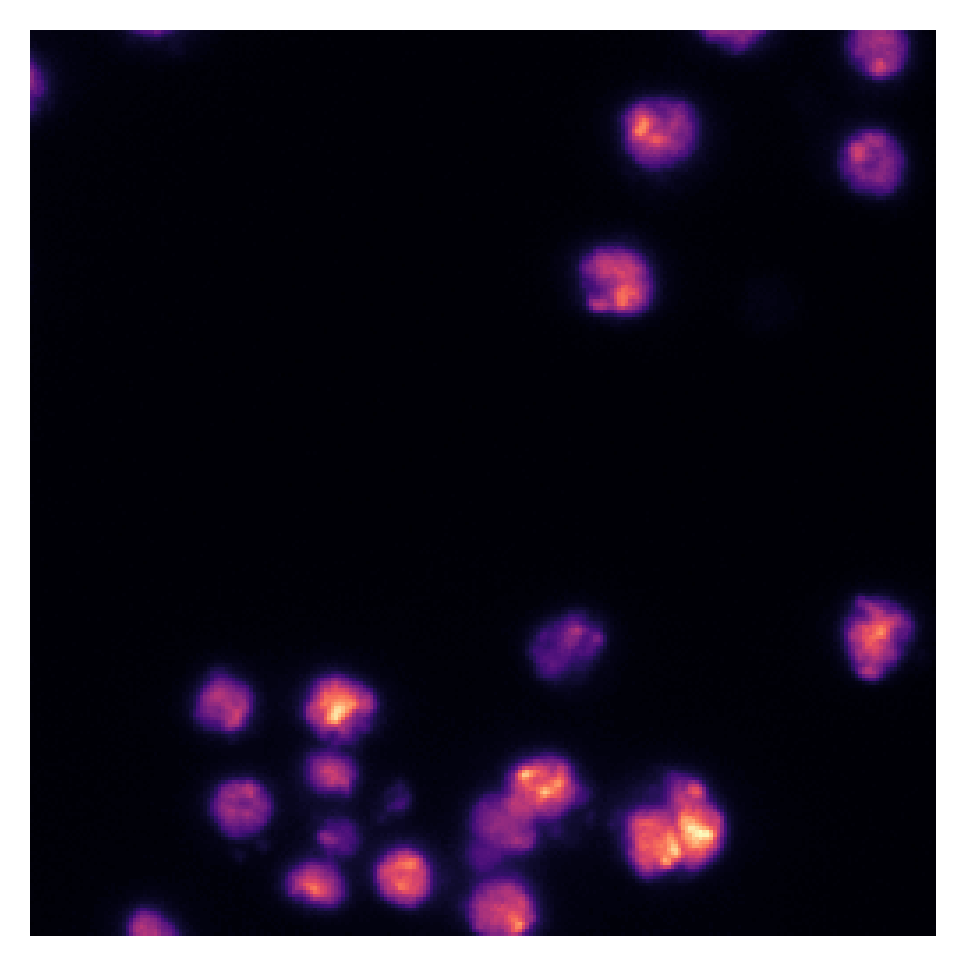

In [33]:
# img = imgs[0][...,2]
img = X[0]
print(img.shape)
plt.imshow(img, cmap='magma')
plt.axis('off')

In [43]:
x = transforms.reshape(img, channels=0)
xx = nd.array(x[np.newaxis, ...], ctx=model0.device)
x.shape, xx.shape

((2, 256, 256), (1, 2, 256, 256))

In [11]:
IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(x, bsize=224)
IMG = nd.array(IMG, ctx=model0.device)
IMG.shape

(12, 2, 224, 224)

## test hidden layer outputs
https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb

The above method is not available for hybrid block. We have to decompose each block and get output from each block separately. 

the original output style is just the last output of the downsample block 2DAvgPooled and normalized by variance

In [49]:
y, style = cpnet(xx)
y.shape, style.shape

((1, 3, 256, 256), (1, 256))

In [44]:
down = cpnet.downsample(xx)
len(down)

4

In [45]:
down[0].shape, down[1].shape, down[2].shape, down[3].shape

((1, 32, 256, 256), (1, 64, 128, 128), (1, 128, 64, 64), (1, 256, 32, 32))

In [15]:
s = cpnet.make_style(down[-1])
s.shape

(1, 256)

In [16]:
style.shape

(1, 256)

In [46]:
d = down[-1].asnumpy()
d.shape

(1, 256, 32, 32)

In [47]:
dmean = d.mean(axis=(2,3))
dmean.shape

(1, 256)

In [48]:
var = np.sqrt((dmean.flatten()**2).sum())
dmean_norm = dmean/var
dmean_norm.shape

(1, 256)

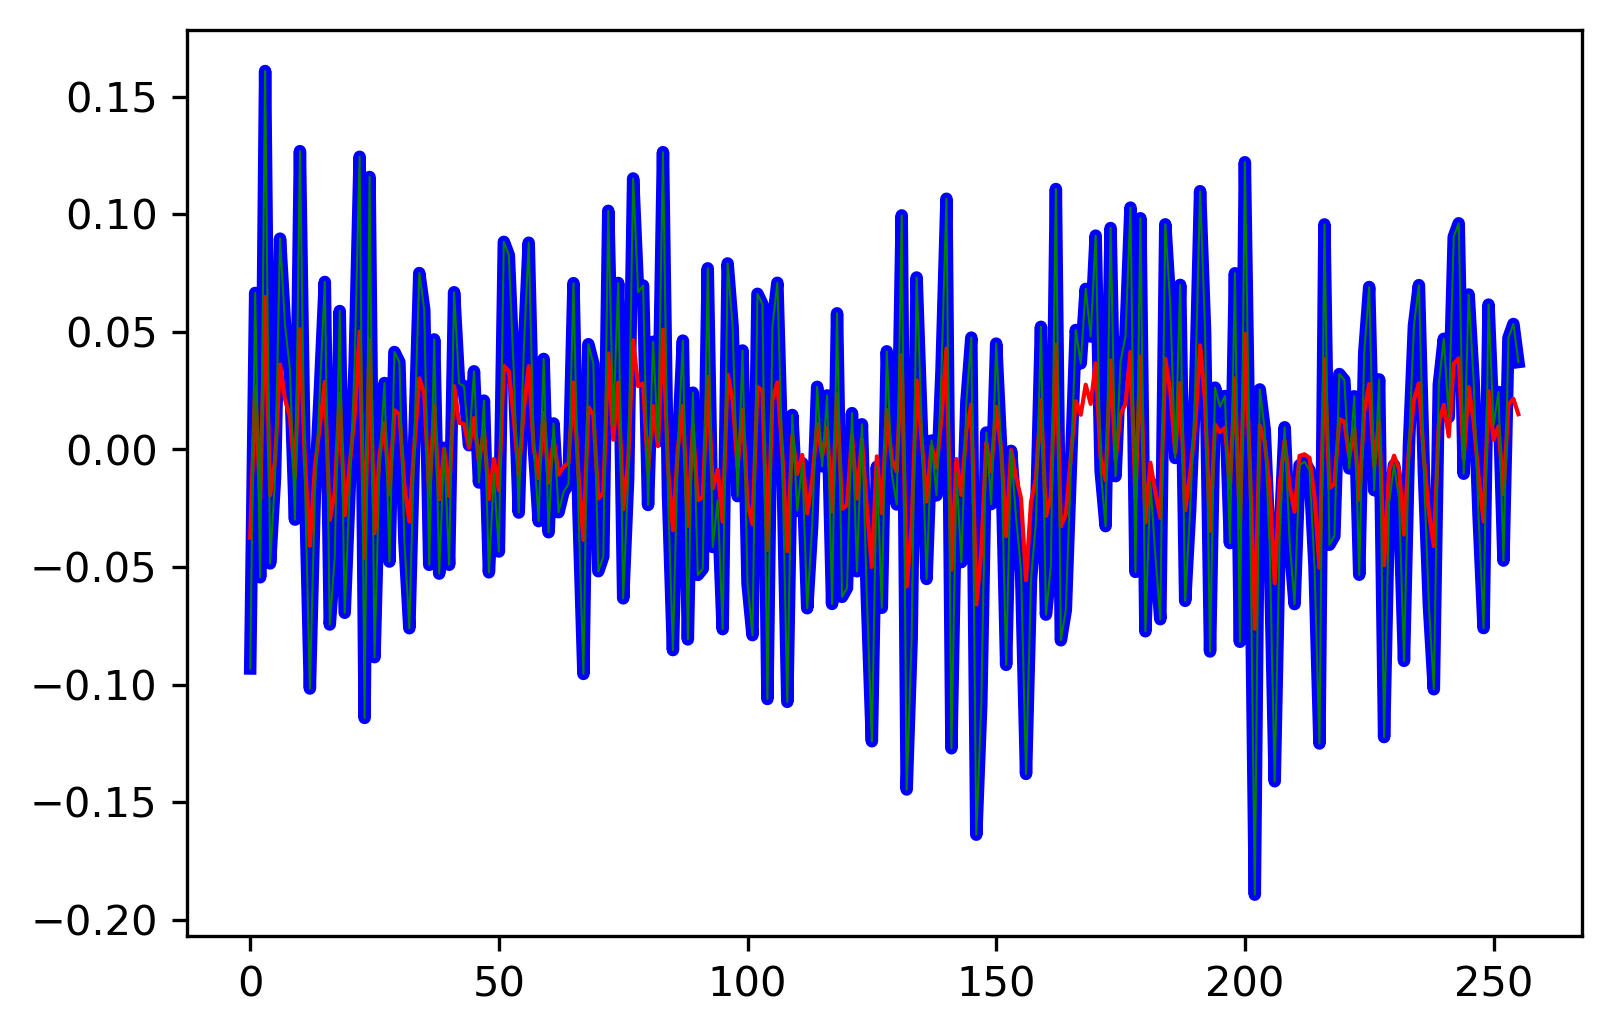

In [53]:
plt.plot(range(0,256), style[0,:].asnumpy(), color='b', linewidth=3)
plt.plot(range(0,256), dmean[0,:], color='r', linewidth=1)
plt.plot(range(0,256), dmean_norm[0,:], color='g', linewidth=.5)
plt.show()

## Use the previously sampled patches 
use stardist/csbdeep sampling function (256x256)

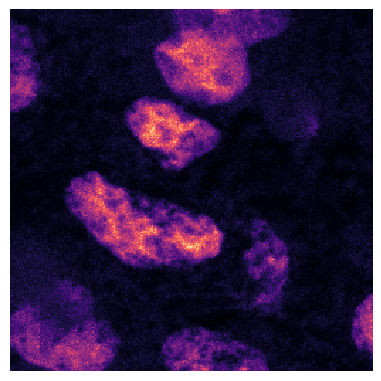

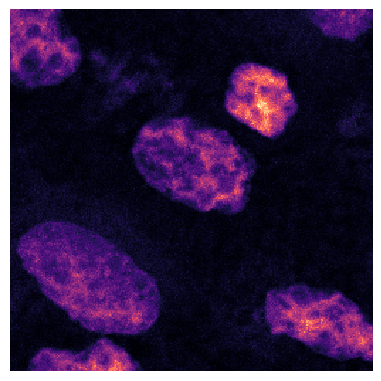

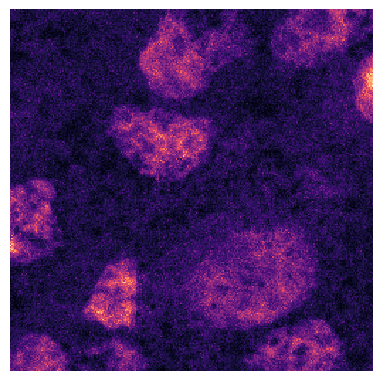

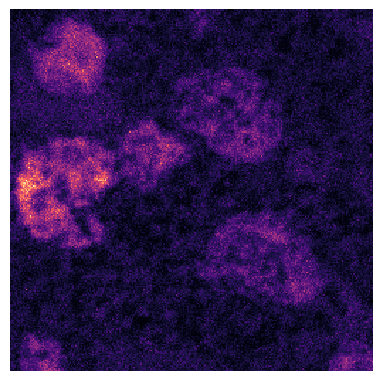

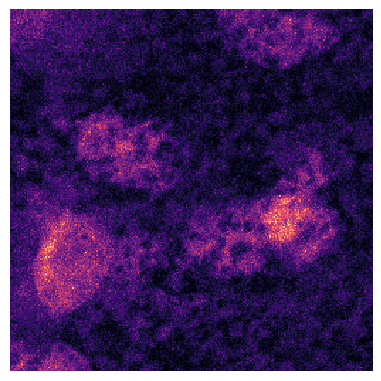

In [6]:
path = '/home/qzt/stardist/examples/2D/patches/'
prefix = 'xenopus_ori_'
X_file = sorted(glob(f'{path}/{prefix}*.tif'))
X = list(map(skimage.io.imread, X_file))
for x in X[:5]:
    plt.figure(figsize=(5,5))
    plt.imshow(x, cmap='magma')
    plt.axis('off')
    plt.show()

In [7]:
%%time
outputs = []
for x in X:
    x = transforms.reshape(x, channels=0)
    xx = nd.array(x[np.newaxis, ...], ctx=model0.device)
#     y, style = cpnet(xx)
#     y.shape, style.shape
    down = cpnet.downsample(xx)
    s = cpnet.make_style(down[-1])
    outputs.append(s.asnumpy())

outputs = np.concatenate(outputs, axis=0)
outputs.shape

CPU times: user 17.4 s, sys: 8.07 ms, total: 17.4 s
Wall time: 4.33 s


(100, 256)

Run the full network will take ~3.5 more time 

In [72]:
# %%time
# outputs = []
# for x in X:
#     x = transforms.reshape(x, channels=0)
#     xx = nd.array(x[np.newaxis, ...], ctx=model0.device)
#     _, style = cpnet(xx)
# #     y.shape, style.shape
# #     down = cpnet.downsample(xx)
# #     s = cpnet.make_style(down[-1])
#     outputs.append(style.asnumpy())

# outputs = np.concatenate(outputs, axis=0)
# outputs.shape

CPU times: user 7min 39s, sys: 1.11 s, total: 7min 40s
Wall time: 1min 53s


(894, 256)

In [8]:
# np.save('featurelayer14_output+idx_patch256_rep2_dsb2018_AUGB1', outputs, allow_pickle=False)
np.save('/home/qzt/stardist/examples/2D/cellpose_style_patch256_xenopus_ori', outputs, allow_pickle=False)

In [69]:
s.shape

(1, 256)